In [1]:
!pip install pymc polars pandas numpy scikit-learn joblib arviz # Core libraries
!pip install numpyro # JAX sampler (alternative: !pip install blackjax)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 kB 12.6 MB/s eta 0:00:00


In [2]:
!pip install jax jaxlib # JAX backend libraries

In [3]:
!pip install blackjax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 9.0 MB/s eta 0:00:00


In [4]:
import polars as pl
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import time
import datetime # To get current date for 2025 end date
import pytensor.tensor as pt
from sklearn.preprocessing import StandardScaler
import joblib # To save the scaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from google.colab import drive
drive.mount('/content/drive')

pl.Config.set_tbl_cols(200)
pl.Config.set_tbl_rows(200)

FILE_PATH = '/content/drive/My Drive/Betting Models/mlb/hits_model/'

Mounted at /content/drive


In [5]:
import jax
import jaxlib

print(f"JAX version: {jax.__version__}")
print(f"jaxlib version: {jaxlib.__version__}")

try:
    devices = jax.devices()
    print("JAX Devices:", devices)
    if any(d.platform.lower() == 'gpu' for d in devices):
         print("SUCCESS: JAX GPU device detected!")
    elif any('cuda' in d.platform.lower() or 'rocm' in d.platform.lower() for d in devices):
         print("SUCCESS: JAX CUDA or ROCm device detected (GPU)!")
    else:
        print("WARNING: No GPU device detected by JAX.")

except Exception as e:
    print(f"Error checking JAX devices: {e}")

JAX version: 0.4.33
jaxlib version: 0.4.33
JAX Devices: [CudaDevice(id=0)]
SUCCESS: JAX GPU device detected!


In [6]:
model_df = pl.read_parquet(f'{FILE_PATH}final_model_data.parquet')

In [7]:
# --- 2. Define Predictor and Outcome Columns ---
outcome_col = "pa_outcome_category"

# List ALL predictor columns you calculated and joined
# Make sure these names exactly match your DataFrame columns
predictor_cols = [
    'is_platoon_adv',
    'is_batter_home',
    # Pitcher Stats
    # 'pitcher_avg_a_daily_input',
    'pitcher_k_pct_a_daily_input',
    'pitcher_bb_pct_a_daily_input',
    'pitcher_hbp_pct_a_daily_input',
    'pitcher_1b_pct_a_daily_input',
    'pitcher_2b_pct_a_daily_input',
    'pitcher_3b_pct_a_daily_input',
    'pitcher_hr_pct_a_daily_input',
    'pitcher_non_k_out_pct_a_daily_input',
    # Add other pitcher rate inputs here (HBP%, 1B%, 2B%, 3B%, HR%) if calculated
    # Batter Stats
    # 'batter_avg_daily_input',
    'batter_k_pct_daily_input',
    'batter_bb_pct_daily_input',
    'batter_hbp_pct_daily_input',
    'batter_1b_pct_daily_input',
    'batter_2b_pct_daily_input',
    'batter_3b_pct_daily_input',
    'batter_hr_pct_daily_input',
    'batter_non_k_out_pct_daily_input',
    # Add other batter rate inputs here (HBP%, 1B%, 2B%, 3B%, HR%) if calculated
    # Context Stats
    'team_defense_oaa_input',
    'park_factor_input',
]

# Identify continuous columns needing scaling vs categorical (like platoon)
continuous_cols = [
    # 'pitcher_avg_a_daily_input',
    'pitcher_k_pct_a_daily_input',
    'pitcher_bb_pct_a_daily_input',
    'pitcher_hbp_pct_a_daily_input',
    'pitcher_1b_pct_a_daily_input',
    'pitcher_2b_pct_a_daily_input',
    'pitcher_3b_pct_a_daily_input',
    'pitcher_hr_pct_a_daily_input',
    'pitcher_non_k_out_pct_a_daily_input',
    # 'batter_avg_daily_input',
    'batter_k_pct_daily_input',
    'batter_bb_pct_daily_input',
    'batter_hbp_pct_daily_input',
    'batter_1b_pct_daily_input',
    'batter_2b_pct_daily_input',
    'batter_3b_pct_daily_input',
    'batter_hr_pct_daily_input',
    'batter_non_k_out_pct_daily_input',
    'team_defense_oaa_input',
    'park_factor_input',
    # Add other continuous rate inputs here
]
categorical_cols = ['is_platoon_adv', 'is_batter_home']

# --- 3. Preprocessing ---

# 3a. Handle Nulls (Drop rows with nulls in predictors or outcome)
print(f"\nShape before dropping nulls: {model_df.shape}")
model_df_clean = model_df.drop_nulls(subset=predictor_cols + [outcome_col])
print(f"Shape after dropping nulls: {model_df_clean.shape}")
if model_df_clean.is_empty():
    raise ValueError("DataFrame is empty after dropping nulls. Check input data and joins.")


Shape before dropping nulls: (186072, 29)
Shape after dropping nulls: (186072, 29)


In [8]:
# 3b. Scaling Continuous Predictors
print("Scaling continuous predictors...")
scaler = StandardScaler()
# Select only continuous columns for scaling
X_continuous_np = model_df_clean[continuous_cols].to_numpy()
X_continuous_scaled_np = scaler.fit_transform(X_continuous_np)

# --- IMPORTANT: Save the scaler ---
# You need to save this scaler to apply the *same* transformation
# to new data when making predictions later.
scaler_filename = "pa_outcome_scaler.joblib"
joblib.dump(scaler, f'{FILE_PATH}{scaler_filename}')
print(f"Scaler saved to {scaler_filename}")

# 3c. Combine Scaled Continuous and Categorical Features
X_categorical_np = model_df_clean[categorical_cols].to_numpy()
# Concatenate numpy arrays horizontally
X_np = np.concatenate([X_continuous_scaled_np, X_categorical_np], axis=1)

# 3d. Prepare Outcome Variable
y_np = model_df_clean[outcome_col].to_numpy()

# 3e. Get Dimensions
n_observations = X_np.shape[0]
n_predictors = X_np.shape[1]
# Determine number of categories (e.g., 0 through 7 -> 8 categories)
# Ensure categories are 0-indexed and contiguous
unique_categories = np.unique(y_np)
n_categories = len(unique_categories)
print(f"\nData prepared for PyMC:")
print(f"  Observations: {n_observations}")
print(f"  Predictors: {n_predictors}")
print(f"  Outcome Categories: {n_categories} (Values: {unique_categories})")
if not np.all(unique_categories == np.arange(n_categories)):
     print("Warning: Outcome categories may not be contiguous 0-indexed integers. Check 'pa_outcome_category'.")

Scaling continuous predictors...
Scaler saved to pa_outcome_scaler.joblib

Data prepared for PyMC:
  Observations: 186072
  Predictors: 20
  Outcome Categories: 8 (Values: [0 1 2 3 4 5 6 7])


In [9]:
# --- 4. Define PyMC Multinomial Logistic Regression Model ---

print("\nDefining PyMC model...")
with pm.Model() as multi_outcome_model:
    # --- Priors ---
    # Intercepts: one for each category, set last category's intercept to 0 for identifiability
    intercepts_offset = pm.Normal("intercepts_offset", mu=0, sigma=1.5, shape=(n_categories - 1,))
    intercepts = pm.Deterministic("intercepts", pt.concatenate([intercepts_offset, pt.zeros(1)]))

    # Coefficients (Betas): matrix of shape (n_predictors, n_categories)
    # Set last category's betas to 0 for identifiability
    betas_offset = pm.Normal("betas_offset", mu=0, sigma=1.0, shape=(n_predictors, n_categories - 1))
    betas = pm.Deterministic("betas", pt.concatenate([betas_offset, pt.zeros((n_predictors, 1))], axis=1))
    beta_batter_home = pm.Normal("beta_batter_home", mu=0, sigma=0.5) # Prior for home advantage effect

    # --- Linear Predictor (mu) ---
    # Calculate log-odds relative to the reference category (last one)
    mu = intercepts + X_np @ betas # Shape: (n_observations, n_categories)

    # --- Softmax Transformation ---
    # Convert log-odds to probabilities that sum to 1 across categories
    p = pm.math.softmax(mu, axis=1)

    # --- Likelihood ---
    # Use Categorical distribution for multi-class outcome
    outcome = pm.Categorical("outcome", p=p, observed=y_np)


Defining PyMC model...


In [10]:
# --- Train the Model (Run MCMC Sampling using JAX on GPU) ---
n_draws = 1000
n_tune = 1000
n_chains = 2 # Can often run more chains in parallel on GPU if memory allows

print(f"\nStarting MCMC sampling with JAX backend ({n_draws} draws / {n_tune} tune / {n_chains} chains)...")
start_time = time.time()
with multi_outcome_model:
    try:
        # Specify the JAX sampler
        idata = pm.sample(
            n_draws,
            tune=n_tune,
            chains=n_chains,
            cores=n_chains, # Often set cores = chains for parallel sampling
            nuts_sampler="numpyro", # Use 'numpyro' or 'blackjax'
            random_seed=42,
            target_accept=0.90 # Adjust if needed
        )
        print("Sampling complete.")
    except Exception as e:
        print(f"\n--- SAMPLING FAILED ---")
        print(f"Error during JAX sampling: {e}")
        print("Possible issues:")
        print("- Check JAX / numpyro / blackjax installation.")
        print("- Ensure GPU was detected by JAX (Step 3).")
        print("- Check model definition for issues.")
        print("- GPU memory exhaustion (try reducing chains or data size).")
        idata = None # Set idata to None if sampling failed

end_time = time.time()


Starting MCMC sampling with JAX backend (1000 draws / 1000 tune / 2 chains)...


sample: 100%|██████████| 2000/2000 [3:00:41<00:00,  5.42s/it, 1023 steps of size 3.94e-03. acc. prob=0.90]


Sampling complete.


In [11]:
if idata:
    idata.to_netcdf(f"{FILE_PATH}multi_outcome_model.nc")

In [12]:
if idata:
    print(f"Sampling took {end_time - start_time:.2f} seconds.")

    # --- Basic Analysis ---
    print("\nModel Summary (Sample):")
    summary = az.summary(idata, var_names=["intercepts_offset", "~betas"], round_to=3) # ~ excludes high-dim betas
    print(summary)
else:
    print("Skipping summary as sampling failed.")

Sampling took 21715.02 seconds.

Model Summary (Sample):
                       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_batter_home      0.022  0.477  -0.855    0.910      0.007    0.012   
betas_offset[0, 0]    0.035  0.670  -1.220    1.331      0.035    0.025   
betas_offset[0, 1]    0.009  0.658  -1.198    1.248      0.032    0.023   
betas_offset[0, 2]   -0.004  0.674  -1.368    1.158      0.035    0.025   
betas_offset[0, 3]   -0.014  0.696  -1.280    1.326      0.034    0.024   
...                     ...    ...     ...      ...        ...      ...   
intercepts_offset[2]  1.266  0.047   1.173    1.352      0.003    0.002   
intercepts_offset[3] -1.395  0.088  -1.548   -1.222      0.004    0.003   
intercepts_offset[4]  0.984  0.048   0.899    1.078      0.003    0.002   
intercepts_offset[5]  3.055  0.043   2.976    3.135      0.003    0.002   
intercepts_offset[6]  1.771  0.045   1.689    1.855      0.003    0.002   

                      ess_bulk  ess_tail  

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


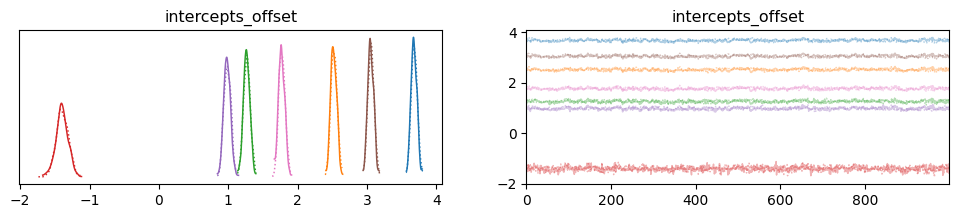

In [13]:
# --- Remember to check convergence (R-hat, ESS, trace plots) ---
if idata:
    az.plot_trace(idata, var_names=["intercepts_offset"]) # Example trace plot

In [ ]:
# import pickle
# import cloudpickle

# pickle_filepath = f'{FILE_PATH}pickle.pkl'
# dict_to_save = {
#     'model': 'multi_outcome_model',
#     'idata': idata,
# }

# with open(pickle_filepath , 'wb') as buff:
#     cloudpickle.dump(dict_to_save, buff)

In [ ]:
# pickle_filepath = f'path/to/pickle.pkl'
# with open(pickle_filepath , 'rb') as buff:
#     model_dict = cloudpickle.load(buff)

# idata = model_dict['idata']
# model = model_dict['model']

# with model:
#     ppc_logit = pm.sample_posterior_predictive(idata )

In [ ]:
# # --- 6. Basic Analysis (Optional) ---
# print("\nModel Summary (Priors and Hyperpriors):")
# # Filter for key parameters to keep summary concise
# summary = az.summary(idata, var_names=["intercepts_offset", "betas_offset"], round_to=3)
# print(summary)

# --- IMPORTANT NEXT STEPS ---
# 1. Check Convergence: Use ArviZ functions like az.plot_trace(idata), check R-hat in summary.
# 2. Save Model: Save the idata object (e.g., idata.to_netcdf("multi_outcome_model.nc")).
# 3. Prediction: Write a separate function to load the model/idata and the scaler,
#    process new input data (scaling it with the *saved* scaler), and use
#    pm.sample_posterior_predictive to generate outcome probabilities for new matchups.
# 4. Inning Simulation: Use the predicted probabilities from step 3 to run your inning simulations.

In [ ]:
# --- 5. Train the Model (Run MCMC Sampling) ---
# WARNING: This will be computationally intensive and take time!
# n_draws = 1000 # Increase for final run
# n_tune = 1000  # Increase for final run
# n_chains = 4   # Use 4 for better diagnostics if possible
# n_cores = 4
# n_target_accept = 0.90
# n_random_seed = 42

# print(f"\nStarting MCMC sampling ({n_draws} draws / {n_tune} tune / {n_chains} chains)...")
# with multi_outcome_model:
#     idata = pm.sample(n_draws, tune=n_tune, chains=n_chains, cores=n_cores, # Set cores appropriately
#                       target_accept=n_target_accept, random_seed=n_random_seed) # Use random seed for reproducibility
# print("Sampling complete.")